# Exercise 6: Speech Enhancement

In [1]:
from typing import Tuple

import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, lfilter
from scipy.linalg import solve_toeplitz
from IPython.display import Audio
import math


%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [18]:
# "Import" functions from previous exercises

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
    ],
)
import_function_from_ipynb(
    "exercise2.ipynb",
    [
        "compute_stft",
        "plot_log_spectrogram"
    ]
)
import_function_from_ipynb(
    "exercise3.ipynb",
    [
        "estimate_filter",
        "plot_dft",
    ]
)

Downloaded import_funcs.py
Found exercise1.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise1\exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']
Found exercise2.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise2\exercise2.ipynb
Executed function compute_stft
Executed function plot_log_spectrogram
Successfully imported functions: ['compute_stft', 'plot_log_spectrogram']
Found exercise3.ipynb: C:\Users\Natia_Mestvirishvili\Desktop\UHH\SSP\ssp_sose2023\Exercise3\exercise3.ipynb
Executed function estimate_filter
Executed function plot_dft
Successfully imported functions: ['estimate_filter', 'plot_dft']


## 1 Noise Power Estimation

In [3]:
x_white, fs = librosa.core.load("AudioFiles/SpeechWhite.wav", sr=None)
print(f"Samples: {len(x_white)}, sampling frequency: {fs} Hz")

Samples: 69466, sampling frequency: 16000 Hz


In [4]:
x_babble, fs = librosa.core.load("AudioFiles/SpeechBabble.wav", sr=None)
print(f"Samples: {len(x_babble)}, sampling frequency: {fs} Hz")

Samples: 69466, sampling frequency: 16000 Hz


In [5]:
# Compute STFT with 
frame_length = 32
frame_shift = 16
sqrt_hann = np.sqrt(get_window("hann", frame_length * fs // 1000))
m_stft, v_freq, frame_centers = compute_stft(x_babble, fs, frame_length, frame_shift, sqrt_hann)
print(m_stft.shape)

Output matches np.fft.rfft: True
(270, 257)


In [6]:
# Compute periodogram of speech signal
periodogram = np.square(m_stft) # idk?
Y = m_stft

# Initialize empty matrices
periodogram_noise_sq = np.zeros_like(m_stft)
m_spp = np.zeros_like(m_stft)
m_noise_psd = np.zeros_like(m_stft)
Q = np.zeros_like(m_stft)

In [7]:
theta = 15
init_sigma_hat = 0.99
init_Q = 0.01

In [8]:
init_sigma_hat = (np.abs(m_stft[:, :10]) ** 2).mean(1)
for l in range(0, periodogram.shape[1]):
    for k in range(0, periodogram.shape[0]):
        Y_k_l_squared = np.square(np.abs(Y[k][l]))
        if (l==0):
            sigma_hat_sq = init_sigma_hat[k]
        else:
            sigma_hat_sq = m_noise_psd[k][l-1]

        p =  1 / (np.exp(-1 * Y_k_l_squared * theta / (sigma_hat_sq * (1 + theta))) * (1 + theta) + 1)
        if np.isnan(p):
            print((sigma_hat_sq))
        if (l==0):
            Q_k_l = init_Q
        else:
            Q_k_l = 0.9 * Q[k][l-1] + 0.1 * p
        
        if (Q_k_l > 0.99):
            p = min(0.99, p)
        m_spp[k][l] = p
        
        periodogram_noise_sq[k][l] = p * sigma_hat_sq + (1 - p) * Y_k_l_squared
        m_noise_psd[k][l] = 0.8 * sigma_hat_sq + 0.2 * periodogram_noise_sq[k][l]
        

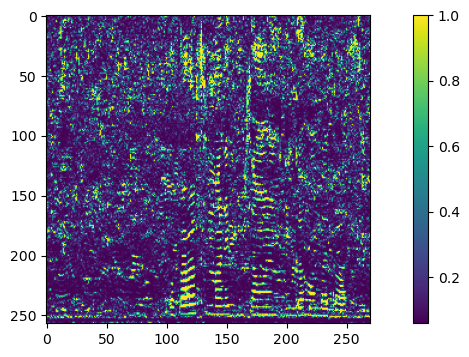

In [23]:
plt.imshow(np.rot90(m_spp.real))
plt.colorbar()
# TODO Plot estimated noise PSD 

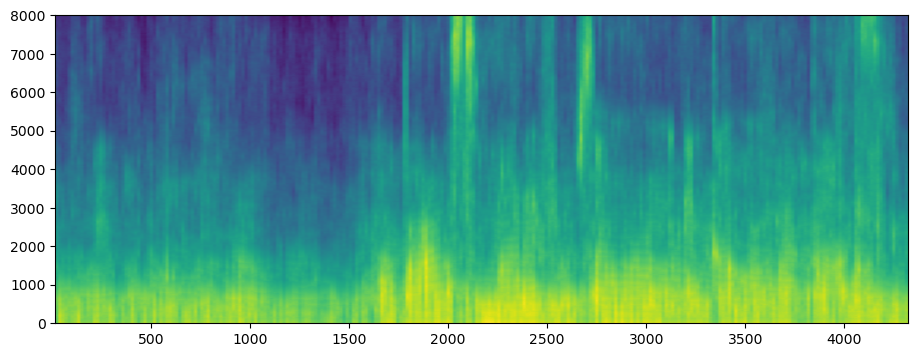

In [65]:
# plt.imshow(np.log(m_noise_psd.real))

magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_noise_psd.real.T)), 10 ** (-15)))
#magnitude = np.abs(m_stft.T)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(
    magnitude,
    cmap="viridis",
    origin="lower",
    extent=[frame_centers[0], frame_centers[-1], v_freq[0], v_freq[-1]],
    aspect="auto",
)

In [ ]:
m_noise_psd.max(), m_noise_psd.min()

## 2 Priori SNR estimation and Wiener filtering

In [58]:
m_enhanced_stft = np.zeros_like(m_stft)
init_S = m_stft[:, 0] # TODO IDK how to init this
priori_estimates = np.zeros_like(m_stft)

alpha = 0.9
G_min = 0.1

for l in range(0, priori_estimates.shape[1]):
    for k in range(0, priori_estimates.shape[0]):
        if (l==0):
            S = 0
        else:
            S = m_enhanced_stft[k][l-1]
        
        priori = alpha * np.power(np.abs(m_enhanced_stft[k][l-1]), 2) / m_noise_psd[k][l-1]
        priori += (1-alpha)*max((np.power(np.abs(Y[k][l]),2)/m_noise_psd[k][l] - 1),0)
        
        G = max(priori/(1+priori), G_min)
        m_enhanced_stft[k][l] = G * Y[k][l]
        

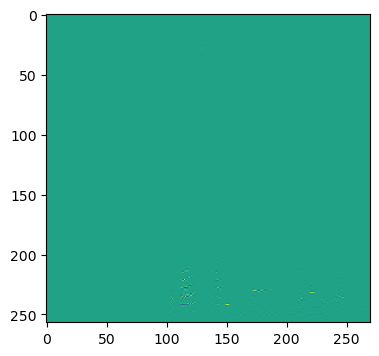

In [59]:
plt.imshow(np.rot90(m_enhanced_stft.real))

In [60]:
from code_exercise2 import compute_istft
from IPython.display import Audio

In [61]:
s_enhanced = compute_istft(m_enhanced_stft, fs, frame_shift, sqrt_hann)

Output matches np.fft.rfft: True


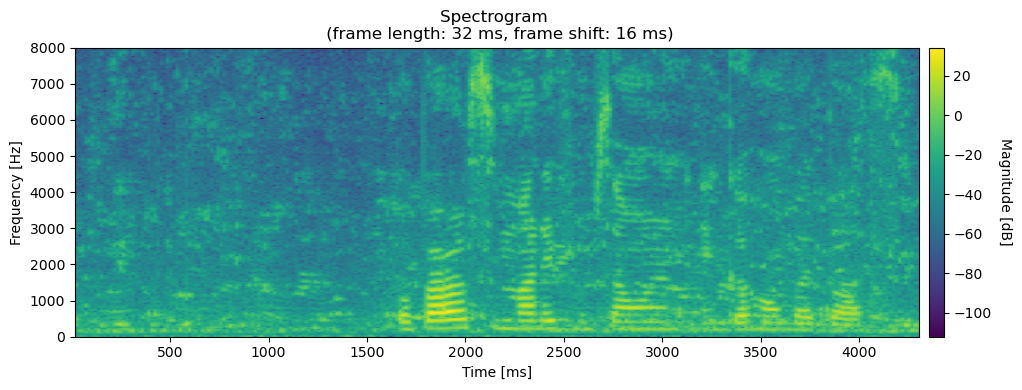

In [62]:
plot_log_spectrogram(s_enhanced, fs, frame_length, frame_shift)

Output matches np.fft.rfft: True


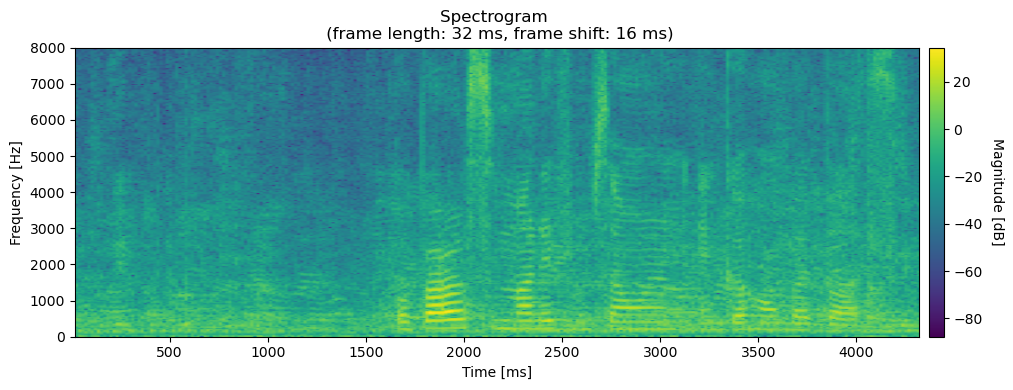

In [63]:
plot_log_spectrogram(x_babble, fs, frame_length, frame_shift)

In [64]:
Audio(s_enhanced, rate=fs)